<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/denoising_local_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localized PCA for Signal Denoising (Tutorial)
(Fayyaz Minhas)

In this tutorial, we will:
1. Generate a synthetic ECG signal with noise.
2. Create a time-delay embedding of the noisy signal.
3. Apply localized PCA to denoise the signal.
4. Compare the original, noisy, and denoised signals in both time and embedding spaces.

# Step 1: Generate Synthetic ECG Signal
We start by simulating a noisy ECG signal using a simple PQRST model.


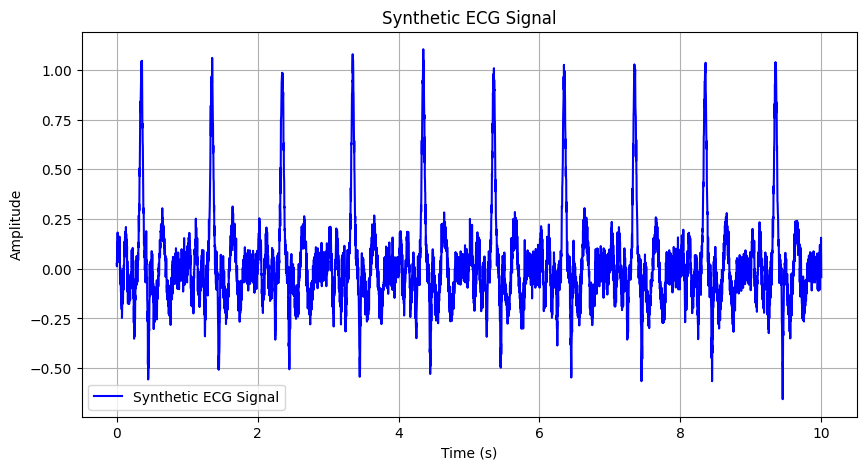

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a synthetic ECG signal using a basic model of heartbeats
def generate_fake_ecg(t, heart_rate=60, noise_level=0.02):
    # Number of beats per second (convert heart rate to frequency)
    frequency = heart_rate / 60.0

    # Generate the PQRST waveform template (simplified approximation)
    def pqrst_waveform(t):
        p_wave = 0.15 * np.sin(2 * np.pi * (t - 0.1) / 0.1) * (t >= 0) * (t <= 0.2)
        q_wave = -0.3 * np.exp(-((t - 0.25) ** 2) / (2 * 0.01 ** 2)) * (t >= 0.2) * (t <= 0.3)
        r_wave = 1.0 * np.exp(-((t - 0.35) ** 2) / (2 * 0.02 ** 2)) * (t >= 0.3) * (t <= 0.4)
        s_wave = -0.5 * np.exp(-((t - 0.45) ** 2) / (2 * 0.01 ** 2)) * (t >= 0.4) * (t <= 0.5)
        t_wave = 0.2 * np.sin(2 * np.pi * (t - 0.6) / 0.2) * (t >= 0.5) * (t <= 0.8)
        return p_wave + q_wave + r_wave + s_wave + t_wave

    # Time points for one heartbeat
    beat_time = np.linspace(0, 1, 500)

    # Construct the synthetic ECG signal by repeating the PQRST waveform
    ecg_signal = np.zeros_like(t)
    for i in range(int(len(t) / len(beat_time))):
        start_idx = i * len(beat_time)
        end_idx = start_idx + len(beat_time)
        if end_idx <= len(t):
            # Align the PQRST waveform with the current time slice and add noise
            ecg_signal[start_idx:end_idx] = pqrst_waveform(beat_time) + noise_level * np.random.randn(len(beat_time))

    return ecg_signal

# Generate time points and the synthetic ECG signal
t = np.linspace(0, 10, 5000)  # Simulate for 10 seconds
fake_ecg_signal = generate_fake_ecg(t, heart_rate=70, noise_level=0.05)

# Plot the synthetic ECG signal
plt.figure(figsize=(10, 5))
plt.plot(t, fake_ecg_signal, label='Synthetic ECG Signal', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

## Step 2: Time-Delay Embedding
A time-delay embedding maps the one-dimensional time series into a higher-dimensional space by constructing vectors of delayed samples of the original signal. This transformation can reveal hidden patterns and structures in the data.

$$
\mathbf{x}_e[n] = \begin{bmatrix}
x[n] \\
x[n + 1] \\
x[n + 2] \\
\vdots \\
x[n + d - 1]
\end{bmatrix} \in R^d
$$



We will embed the noisy ECG signal using the time-delay embedding technique, where each vector consists of `embedding_dimension` delayed points and generate the scatter plot.


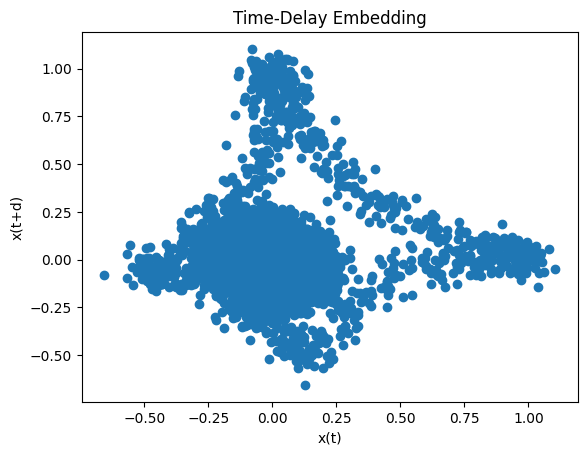

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import KDTree

# Function to create a time-delay embedding of the time series
def time_delay_embedding(signal, delay, dimension):
    embedded_data = np.array([signal[i:i + dimension * delay:delay] for i in range(len(signal) - (dimension - 1) * delay)])
    return embedded_data

# Generate synthetic signal with noise for demonstration
np.random.seed(42)

noisy_signal = fake_ecg_signal

# Step 1: Time-delay embedding
embedding_dimension = 30
time_delay = 1
embedded_data = time_delay_embedding(noisy_signal, time_delay, embedding_dimension)
plt.figure();plt.scatter(embedded_data[:,0],embedded_data[:,-1]);plt.xlabel('x(t)');plt.ylabel('x(t+d)');plt.title('Time-Delay Embedding');

## Step 3: Localized PCA Denoising
We will now apply localized PCA to denoise the signal:
1. For each point in the embedded space, find its local neighborhood using a k-d tree which is an efficient way of finding neighboring points.
2. Perform PCA on the local neighborhood to capture dominant directions.
3. Retain components that explain most of the variance (based on a cumulative variance threshold).
4. Reconstruct the signal using the retained components.

This technique preserves the signal's local structure while reducing noise.


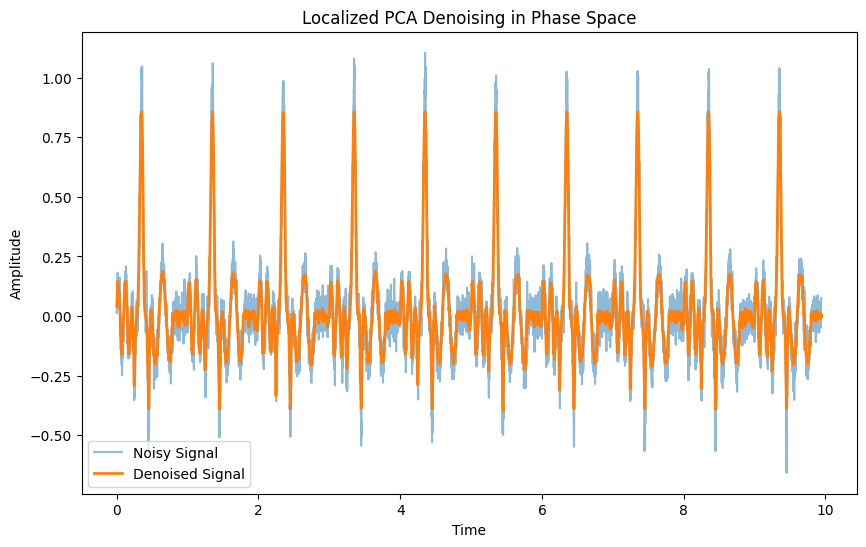

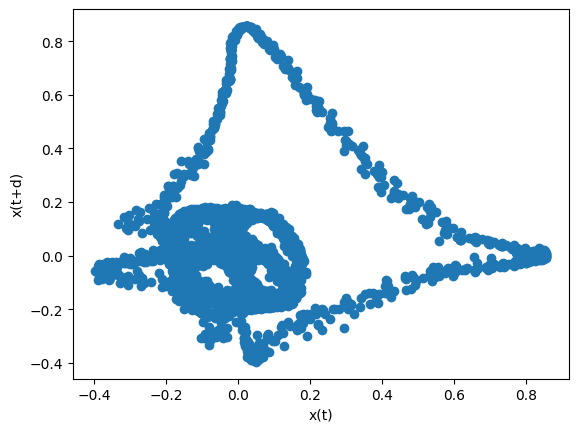

In [75]:
# Step 2: Define function for localized PCA denoising
def localized_pca_denoising(embedded_data, neighborhood_size=200, variance_threshold=0.05):
    denoised_data = np.zeros_like(embedded_data)
    kdtree = KDTree(embedded_data)  # Build a KDTree for fast neighborhood search

    for i in range(embedded_data.shape[0]):
        # Step 3: Find local neighborhood
        distances, neighbors = kdtree.query(embedded_data[i], k=neighborhood_size)
        local_points = embedded_data[neighbors]

        # Step 4: Perform PCA on local neighborhood
        pca = PCA()
        pca.fit(local_points)

        # Determine number of components to keep
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components = np.searchsorted(cumulative_variance, variance_threshold) + 1

        # Step 5: Project onto retained principal components and reconstruct
        projected_point = pca.transform([embedded_data[i]])[:, :num_components]
        local_denoised = pca.inverse_transform(np.hstack((projected_point, np.zeros((1, pca.n_components_ - num_components)))))
        denoised_data[i] = local_denoised

    return denoised_data[:, 0]  # Return the denoised version of the first coordinate

# Step 6: Apply localized PCA denoising
denoised_signal = localized_pca_denoising(embedded_data)

# Step 7: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t[:-embedding_dimension + 1], noisy_signal[:-embedding_dimension + 1], label='Noisy Signal', alpha=0.5)
plt.plot(t[:-embedding_dimension + 1], denoised_signal, label='Denoised Signal', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Localized PCA Denoising in Phase Space')
plt.show()
denoised_embedded_data = time_delay_embedding(denoised_signal, time_delay, embedding_dimension)
plt.scatter(denoised_embedded_data[:,0],denoised_embedded_data[:,-1]);plt.xlabel('x(t)');plt.ylabel('x(t+d)');